# Índice

[1. Importa as Libs](#Importa_Libs)<br>
[2. Manipualação de Dados](#Manipulação_Dados)<br>
&nbsp;&nbsp;&nbsp;[2.1 Modifica campos que já tem na tabela origem](#Manipulação_Dados_mudanca_ja_tem)<br>
&nbsp;&nbsp;&nbsp;[2.2 Cria funções para manipular os comentários, e cria alguns campos adicionais para a Análise Exploratória](#Manipulação_Dados_funcoes)<br>
[3. Análise Exploratória](#Analise_exploratoria)<br>
&nbsp;&nbsp;&nbsp;[3.1 Monta WordCloud de cada uma das classes](#Analise_exploratoria_wordcloud)<br>
&nbsp;&nbsp;&nbsp;[3.2 Monta Gráficos Quantitativos](#Analise_exploratoria_quantitativos)<br>
[4. Modelagem](#Modelagem)<br>
&nbsp;&nbsp;&nbsp;[4.1 Aplica TF IDF](#Modelagem_tfidf)<br>

<a id = "Importa_Libs"></a>

# 1. Importa Libs

In [49]:
#Sistema operacional
from os import path


#Manipulação de Dados
import pandas as pd
import numpy as np
import datetime


#Opções
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings("ignore")


#manipulação de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Gráficos e Imagens
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB

In [50]:
#Precisa rodar esse comando 1 vez para fazer download dos dados de linguas de nltk
# import nltk
# nltk.download('all')

<a id = "Manipulação_Dados"></a>

# 2. Manipulação de Dados

<a id = "Manipulação_Dados_mudanca_ja_tem"></a>

### 2.1 Modifica campos que já tem na tabela origem

In [51]:
#Importa a base de comentários
df = pd.read_excel(io = '..\data\Comentários para classificação.xlsx', sheet_name = 'Sheet1', header = 0)

#Mantém apenas as colunas que usarei
df = df[['textDisplay', 'likeCount', 'publishedAt', 'É homofóbico']]

#Renomeia colunas
df.rename(columns = {'textDisplay': 'comentario', 
                     'likeCount': 'qtde_likes',
                     'publishedAt': 'data_publicacao',
                     'É homofóbico': 'target'},
          inplace = True)

#Filtra somente os casos que tenho informação de target
df.dropna(subset = ['target'], inplace = True)


#Muda o tipo das colunas
df['target'] = df['target'].astype(int)
df['qtde_likes'] = df['qtde_likes'].fillna(value = 0).astype(int)
df['data_publicacao'] = pd.to_datetime(df['data_publicacao'])

<a id = "Manipulação_Dados_funcoes"></a>

### 2.2 Cria funções para manipular os comentários, e cria alguns campos adicionais para a Análise Exploratória

In [52]:
#Faz uma cópia do df anterior
df_2 = df.copy()

In [53]:
#Função que tira os links dos comentários
def tira_links(comentario):
    urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', str(comentario))
    if len(urls) == 0:
        pass
    else:
        for url in urls:
            for link in url:
                comentario = comentario.replace(link, '')
        comentario = comentario.replace(':', '')
        comentario = comentario.replace('/', '')
    return comentario


#Função que tira marcações html e outras marcações do próprio Youtube
def tira_comandos(comentario):
    comentario = str(comentario)
    comentario = comentario.replace('<br>', ' ')
    comentario = comentario.replace('<br />', ' ')
    comentario = comentario.replace('&#39;', ' ')
    comentario = comentario.replace('&quot;', ' ')
    comentario = comentario.replace('@', ' ')
    comentario = comentario.replace('<a href=', ' ')
    comentario = comentario.replace('<a', ' ')
    comentario = comentario.replace(';', ' ')
    comentario = comentario.replace('>', ' ')
    comentario = comentario.replace('<a>', ' ')
    comentario = comentario.replace('t=', ' ')
    comentario = comentario.replace('"', ' ')
    return comentario

#Função que substitui os números por espaço vazio, pois os números podem ser interpretados de formas erradas
def tira_numeros(comentario):
    comentario = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' ', str(comentario))
    return comentario


#Função que remove os caractéres especiais como figuras
def tira_figuras(comentario):
    comentario = re.sub(r'R\$', ' ', str(comentario))
    comentario = re.sub(r'\W', ' ', comentario)
    return comentario


#Função que faz tratamento de algumas letras específicas e risadas kkk, e coloca todo texto em minusculo
def trata_letras_risadas_minisculo(comentario):
    comentario = str(comentario)
    comentario = comentario.lower()
    for i in range(10):
        comentario = comentario.replace('kk', 'k')
    comentario = [word for word in comentario.split() if word not in ('k', 'm', 's')]
    comentario = ' '.join(comentario)
    return comentario
    

#Função que remove espaços em branco adicionais
def tira_espacos_brancos(comentario):
    comentario = str(comentario)
    for i in range(10):
        comentario = comentario.replace('  ', ' ')
    return comentario


#Função para tratar acentuação, tira acentuação
def trata_acentuacao(comentario):
    comentario = str(comentario)
    comentario = comentario.replace('ç', 'c')
    comentario = comentario.replace('á', 'a')
    comentario = comentario.replace('à', 'a')
    comentario = comentario.replace('â', 'a')
    comentario = comentario.replace('ã', 'a')
    comentario = comentario.replace('ä', 'a')
    comentario = comentario.replace('é', 'e')
    comentario = comentario.replace('è', 'e')
    comentario = comentario.replace('ê', 'e')
    comentario = comentario.replace('ë', 'e')
    comentario = comentario.replace('í', 'i')
    comentario = comentario.replace('ì', 'i')
    comentario = comentario.replace('î', 'i')
    comentario = comentario.replace('ï', 'i')
    comentario = comentario.replace('ó', 'o')
    comentario = comentario.replace('ò', 'o')
    comentario = comentario.replace('ô', 'o')
    comentario = comentario.replace('ö', 'o')
    comentario = comentario.replace('õ', 'o')
    comentario = comentario.replace('ú', 'u')
    comentario = comentario.replace('ù', 'u')
    comentario = comentario.replace('û', 'u')
    comentario = comentario.replace('ü', 'u')
    return comentario


#Função que trata repetição de letras
def trata_repet_letras(comentario):
    comentario = str(comentario)
    for i in range(10):
        comentario = comentario.replace('aa', 'a')
        comentario = comentario.replace('bb', 'b')
        comentario = comentario.replace('cc', 'c')
        comentario = comentario.replace('dd', 'd')
        comentario = comentario.replace('ee', 'e')
        comentario = comentario.replace('ff', 'f')
        comentario = comentario.replace('gg', 'g')
        comentario = comentario.replace('hh', 'h')
        comentario = comentario.replace('ii', 'i')
        comentario = comentario.replace('jj', 'j')
        comentario = comentario.replace('ll', 'll')
        comentario = comentario.replace('mm', 'm')
        comentario = comentario.replace('nn', 'n')
        comentario = comentario.replace('oo', 'o')
        comentario = comentario.replace('pp', 'p')
        comentario = comentario.replace('qq', 'q')
        comentario = comentario.replace('uu', 'u')
        comentario = comentario.replace('vv', 'v')
        comentario = comentario.replace('xx', 'x')
        comentario = comentario.replace('ww', 'w')
        comentario = comentario.replace('yy', 'y')
    return comentario
        

#Função que remove stopwords e pontuações
def tira_stop_words(comentario):
    comentario = [word for word in comentario.split() if word.lower() not in stopwords.words('portuguese')]
    return comentario


#Função para fazer o stemming
def faz_stemming(comentario):
    stemmer = RSLPStemmer()
    phrase = []
    for word in comentario:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

In [54]:
#Aplica todas as funções

#Tira links que colocaram nos comentários
df_2['comentario_trat'] = df_2.comentario.apply(tira_links)

#Tira comandas html e do Youtube
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_comandos)

#Tira númemos
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_numeros)

#Tira figuras(emoticons)
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_figuras)

#Coloca tudo em minúsculo, tira outras letras inúteis e risadas kkk
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_letras_risadas_minisculo)

#Tira espaços em branco duplicados
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_espacos_brancos)

#Trata acentuação
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_acentuacao)

#Cria campo com o tamanho do texto em caractéres
df_2['qtde_caract'] = df_2.comentario_trat.apply(lambda e: len(e))

#Trata repetição de letras
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_repet_letras)

#Tira stopwords
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_stop_words)

#Aplica Stemmer
df_2['comentario_stemming'] = df_2.comentario_trat.apply(faz_stemming)

In [55]:
df_2.head()

,comentario,qtde_likes,data_publicacao,target,comentario_trat,qtde_caract,comentario_stemming
0,Wtf quer dizer que quem não quiser é homofóbico?? Mds,0,2020-07-03 11:23:13+00:00,1,"[wtf, quer, dizer, nao, quiser, homofobico, mds]",51,"[wtf, qu, diz, nao, quis, homofob, md]"
1,"Controle de natalidade ainda é tabu no Brasil. Enquanto isso, quem menos tem condição de criar um filho é quem acaba gerando vários. E deixa a conta para a sociedade. A China teve coragem de aplicar um programa de controle de natalidade.",0,2018-05-09 04:27:53+00:00,0,"[controle, natalidade, ainda, tabu, brasil, enquanto, menos, condicao, criar, filho, acaba, gerando, varios, deixa, conta, sociedade, china, coragem, aplicar, programa, controle, natalidade]",232,"[control, natal, aind, tabu, brasil, enquant, menos, condica, cri, filh, acab, ger, vari, deix, cont, sociedad, chin, corag, aplic, program, control, natal]"
2,indepemdente de tudo richarlison era muito craque,0,2019-08-19 21:45:28+00:00,0,"[indepemdente, tudo, richarlison, craque]",49,"[indepemd, tud, richarlison, craqu]"
3,Adorei a lista...tentar ver todos que eu não conhecia ainda!,0,2020-06-13 00:11:43+00:00,0,"[adorei, lista, tentar, ver, todos, nao, conhecia, ainda]",57,"[ador, list, tent, ver, tod, nao, conhec, aind]"
4,Jesus tá voltando,0,2020-02-14 15:08:54+00:00,1,"[jesus, ta, voltando]",17,"[jesu, ta, volt]"


In [56]:
#cria campo com a safra do comentário
df_2['safra_comentario'] = pd.to_datetime(df_2['data_publicacao']).dt.to_period('M')

#Cria campo com o ano do comentário
df_2['ano_comentario'] = df_2['data_publicacao'].dt.year.fillna(value = 0).astype(int)

#Cria campo com a hora do comentário
df_2['hora_comentario'] = df_2['data_publicacao'].dt.hour

<a id = "Analise_exploratoria"></a>

# 3. Análise Exploratória

In [57]:
#Faz cópia do dataframe anterior
df_3 = df_2.copy()

<a id = "Analise_exploratoria_wordcloud"></a>

### 3.1 Monta WordCloud de cada uma das classes

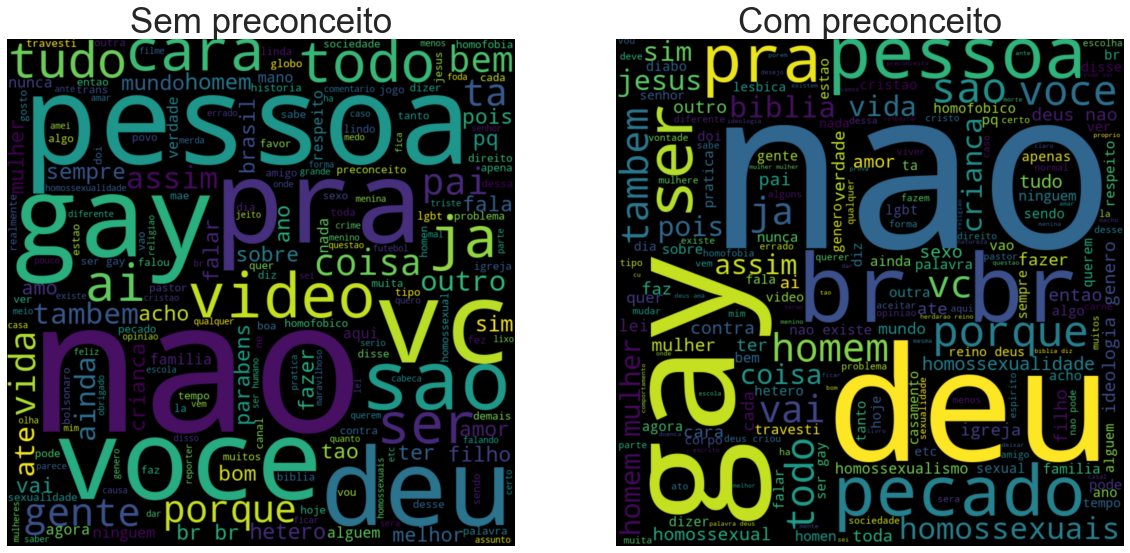

In [58]:
#Cria um novo campo transformando as listas em texto corrido
df_3['comentario_trat_2'] = df_3.comentario_trat.apply(lambda e: ' '.join(e))

#Junta todos os textos em uma única variável para fazer o wordCloud
texto_classe_0 = " ".join(review for review in df_3.comentario_trat_2[(df_3.target == 0)])
texto_classe_1 = " ".join(review for review in df_3.comentario_trat_2[(df_3.target == 1)])

# Gera a imagem do WordCloud
wordcloud_0 = WordCloud(width=800, height=800).generate(texto_classe_0)
wordcloud_1 = WordCloud(width=800, height=800).generate(texto_classe_1)

#Exibe imagens
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Sem preconceito', fontsize = 35)
ax1.imshow(wordcloud_0, interpolation='gaussian')
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Com preconceito', fontsize = 35)
ax2.imshow(wordcloud_1, interpolation='gaussian')
ax2.axis("off")

fig.show()

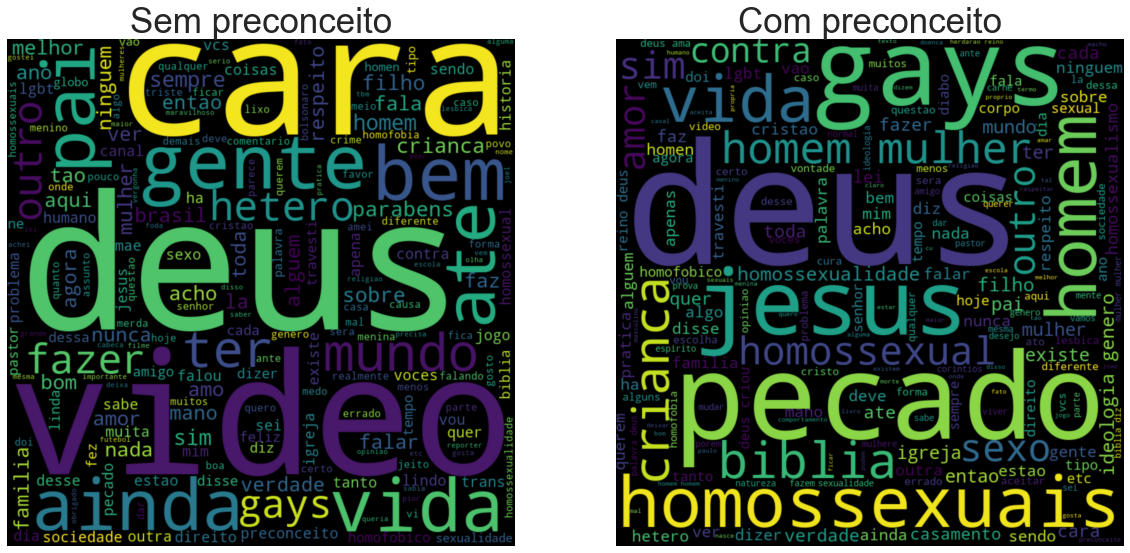

In [59]:
#Refaz o WordCloud com as palavras que aparecem muito nos dois anteriores

#Seleção de palavras pra desconsiderar
palavras_tirar = ['gay', 'br', 'nao', 'pessoa', 'pessoas', 'vc', 'voce', 'para', 'ser', 'deu', 'sao', 'vai', 'tambem', 'tb', 'todo', 'td', 'porque', 'pq', 'ja', 'assim', 'pra', 'tudo', 'todos', 'ta', 'ai',
                  'pois', 'pode', 'coisa']

#Subistitui na base da clase 0
texto_classe_0x = [word for word in texto_classe_0.split() if word not in palavras_tirar]
texto_classe_0x = ' '.join(texto_classe_0x)

#Subistitui na base da clase 1
texto_classe_1x = [word for word in texto_classe_1.split() if word not in palavras_tirar]
texto_classe_1x = ' '.join(texto_classe_1x)

# Gera as imagems novas do WordCloud
wordcloud_0x = WordCloud(width=800, height=800).generate(texto_classe_0x)
wordcloud_1x = WordCloud(width=800, height=800).generate(texto_classe_1x)

#Imprime as imagens
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Sem preconceito', fontsize = 35)
ax1.imshow(wordcloud_0x, interpolation='gaussian')
ax1.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Com preconceito', fontsize = 35)
ax2.imshow(wordcloud_1x, interpolation='gaussian')
ax2.axis("off")
fig.show()

<a id = "Analise_exploratoria_quantitativos"></a>

### 3.2 Monta Gráficos Quantitavos

In [60]:
#Cria nova coluna com a target em forma de texto
df_3['target_x'] = df_3.target.apply(lambda e: 'Sem preconceito' if e == 0 else 'Com preconceito')

#Cria uma nova coluna para valores muito grandes de tamanho dos comentários
df_3['qtde_caract_x'] = df_3.qtde_caract.apply(lambda e: 1000 if e >= 1000 else e)

,comentario
target_x,
Com preconceito,1291
Sem preconceito,10514


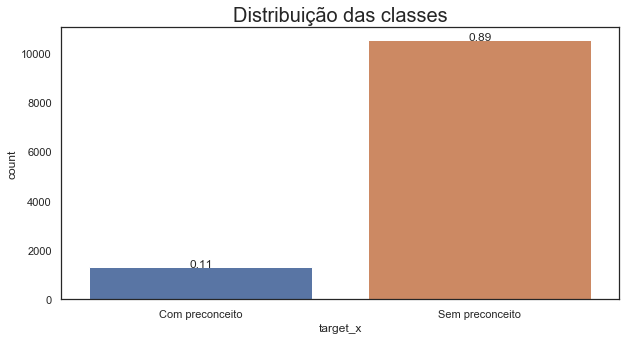

In [150]:
#Distribuição de classes
valor = df_3[['comentario', 'target_x']].groupby(by = ['target_x']).count()
display(valor)

total = float(len(df_3))

plt.figure(figsize=(10,5))
plt.title("Distribuição das classes", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "target_x", data = df_3)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2}'.format(height/total),
            ha="center") 
plt.show()

,target_x,qtde_likes_com_0,qtde_likes_sem_0
0,Com preconceito,1.863003,5.372768
1,Sem preconceito,4.775252,13.345827


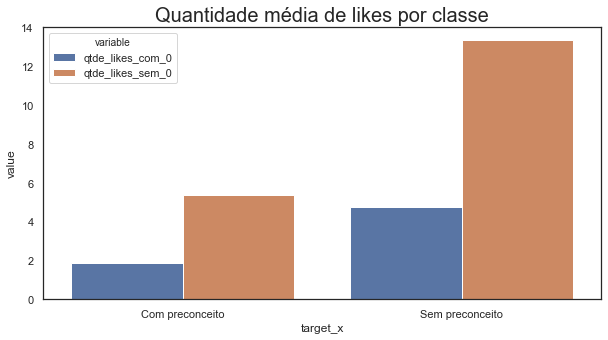

In [154]:
#Média de likes por classe, considerando comentários sem likes
likes_1 = df_3[(df_3.qtde_likes >= 0)][['target_x', 'qtde_likes']].groupby(by = ['target_x']).mean().rename(columns = {'qtde_likes': 'qtde_likes_com_0'})

#Média de likes por classe, desconsiderando comentários sem likes
likes_2 = df_3[(df_3.qtde_likes >= 1)][['target_x', 'qtde_likes']].groupby(by = ['target_x']).mean().rename(columns = {'qtde_likes': 'qtde_likes_sem_0'})

#Junta as duas tabelas
likes_3 = likes_1.merge(likes_2, how = "inner", on = 'target_x')
display(likes_3.reset_index())

#Redefine index
likes_3['target_x'] = likes_3.index

#Transforma a coluna em linha
likes_3 = pd.melt(likes_3, id_vars = 'target_x', value_vars=['qtde_likes_com_0', 'qtde_likes_sem_0'])

#Monta o gráfico
plt.figure(figsize=(10,5))
plt.title("Quantidade média de likes por classe", fontsize=20)
g = sns.barplot(x = 'target_x', y = 'value', hue = 'variable', data = likes_3)

hora_comentario,target_x,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
0,Com preconceito,77,71,67,65,48,36,29,23,16,22,21,39,36,58,60,68,71,84,68,68,77,49,79,59
1,Sem preconceito,632,599,647,533,430,349,242,152,129,139,157,262,353,416,472,558,568,584,529,555,515,556,546,591


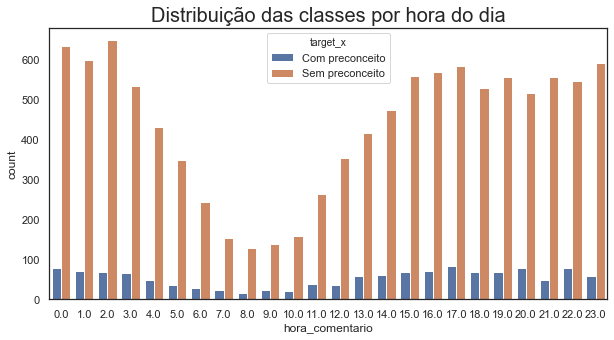

In [160]:
#Distribuição por hora do dia
valor = df_3[['hora_comentario', 'target_x', 'comentario']].groupby(by = ['hora_comentario', 'target_x']).count().reset_index()
valor = valor.pivot(index = 'target_x', columns ='hora_comentario', values = 'comentario').reset_index()
display(valor)

plt.figure(figsize=(10,5))
plt.title("Distribuição das classes por hora do dia", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "hora_comentario", hue = 'target_x', data = df_3)

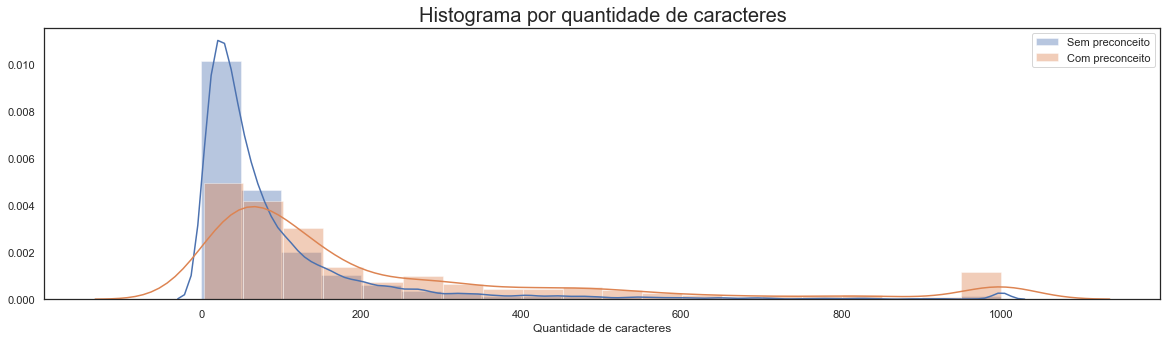

In [71]:
#Distribuição pela quantidade de caractéres dos comentários
plt.figure(figsize=(20,5))
plt.title("Histograma por quantidade de caracteres", fontsize=20)
sns.distplot(a = df_3[(df_3['target'] == 0)]['qtde_caract_x'], bins = 20, label = 'Sem preconceito')
sns.distplot(a = df_3[(df_3['target'] == 1)]['qtde_caract_x'], bins = 20, label = 'Com preconceito')
plt.legend(loc='upper right')
plt.xlabel('Quantidade de caracteres') 
plt.show()

,comentario
ano_comentario,
0,0
2010,21
2011,42
2012,20
2013,87
2014,47
2015,87
2016,164
2017,419


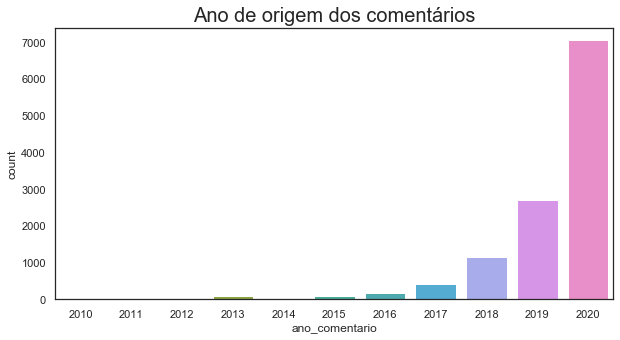

In [162]:
#Em que data se concentram os comentários
valor = df_3[['ano_comentario', 'comentario']].groupby(by = ['ano_comentario']).count()
display(valor)

plt.figure(figsize=(10,5))
plt.title("Ano de origem dos comentários", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "ano_comentario", data = df_3[(df_3['ano_comentario'] > 0)])

<a id = "Modelagem"></a>

# 4. Modelagem

<a id = "Modelagem_tfidf"></a>

### 4.1 Aplica TF IDF

In [65]:
#Copia a base só com os campos que vou utilizar
df_modelagem_1 = df_3[['comentario_trat', 'target']]